In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Функция для загрузки данных из текстового файла
def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # Разделяем строку на метки и текст
            if line.strip():  # Пропускаем пустые строки
                parts = line.strip().split(' ', 1)
                if len(parts) == 2:
                    labels, text = parts
                    data.append({'text': text, 'labels': labels.split(',')})
    return pd.DataFrame(data)

In [9]:
# Загрузка данных
df = load_data('dataset.txt')

# Создаем бинарные колонки для каждой метки
all_labels = set()
for labels in df['labels']:
    for label in labels:
        all_labels.add(label)

for label in all_labels:
    df[label] = df['labels'].apply(lambda x: 1 if label in x else 0)

# Определяем основные категории для анализа
main_labels = ['__label__NORMAL', '__label__INSULT', '__label__THREAT', '__label__OBSCENITY']

# Вычисляем количество комментариев по категориям
label_counts = df[main_labels].sum()

# Выводим статистику
print("Распределение комментариев по категориям:")
print(label_counts)

Распределение комментариев по категориям:
__label__NORMAL       203685
__label__INSULT        36826
__label__THREAT        12027
__label__OBSCENITY      4261
dtype: int64


<ipython-input-10-f6f1ccb3256c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=clean_labels, y=label_counts.values, palette="husl")


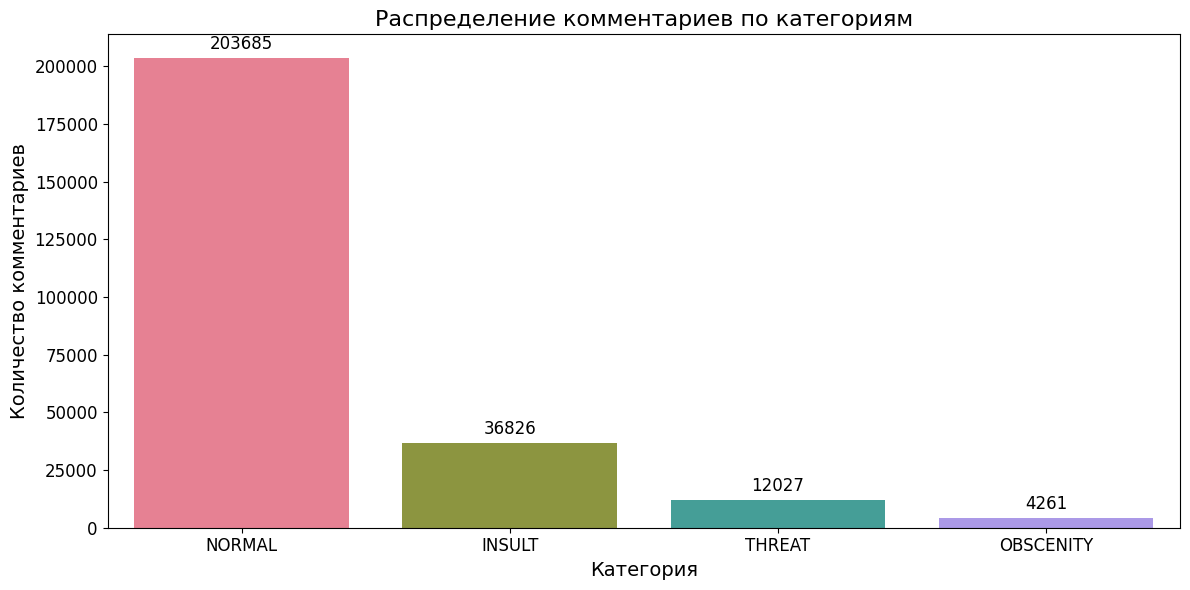

In [10]:
# Визуализация данных
plt.figure(figsize=(12, 6))

# 1. Столбчатая диаграмма
clean_labels = [label.replace('__label__', '') for label in main_labels]
ax = sns.barplot(x=clean_labels, y=label_counts.values, palette="husl")

# Настройки графика
plt.title('Распределение комментариев по категориям', fontsize=16)
plt.xlabel('Категория', fontsize=14)
plt.ylabel('Количество комментариев', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Добавляем подписи значений
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=12)

plt.tight_layout()
plt.show()

In [11]:
import re


def clean_text(text):
    """
    1. Удаление спецсимволов и цифр
    2. Приведение к нижнему регистру
    3. Удаление лишних пробелов
    """
    text = re.sub(r'[^а-яёА-ЯЁ\s]', '', text)  # Удаляем всё, кроме букв и пробелов
    text = text.lower()  # Приводим к нижнему регистру
    text = re.sub(r'\s+', ' ', text).strip()  # Удаляем лишние пробелы
    return text

# Применяем очистку к тексту
df['cleaned_text'] = df['text'].apply(clean_text)

In [12]:
for i, (original, cleaned) in enumerate(zip(df['text'].head(100), df['cleaned_text'].head(100))):
    print(f"\n{i+1}. Оригинал: {original}")
    print(f"   Очищенный: {cleaned}")
    if i >= 99:  # Ограничиваем 100 записями
        break


1. Оригинал: скотина! что сказать
   Очищенный: скотина что сказать

2. Оригинал: я сегодня проезжала по рабочей и между домами снитенко и гомолысовой магазином ( на пустыре) бежала кошка похожего окраса. может, я и ошиблась, но необычный окрас бросился в глаза.
   Очищенный: я сегодня проезжала по рабочей и между домами снитенко и гомолысовой магазином на пустыре бежала кошка похожего окраса может я и ошиблась но необычный окрас бросился в глаза

3. Оригинал: очередной лохотрон. зачем придумывать очередной налог на воздух, если можно обьявить инсульт и грипп- пандемией! и лихо на придурках зарабатывать годами на штрафах, фейковых вакцинах, всевозможных платных тестах, продажей масок и перчаток по баснословным ценам.. самое смешное, что бараны блеют и верят пастуху, телевизору. живут как под гипнозом. не думая, не глядя по сторонам.
   Очищенный: очередной лохотрон зачем придумывать очередной налог на воздух если можно обьявить инсульт и грипп пандемией и лихо на придурках зарабатыват

Heatmap корреляции меток — понять, какие токсичные метки часто сочетаются.

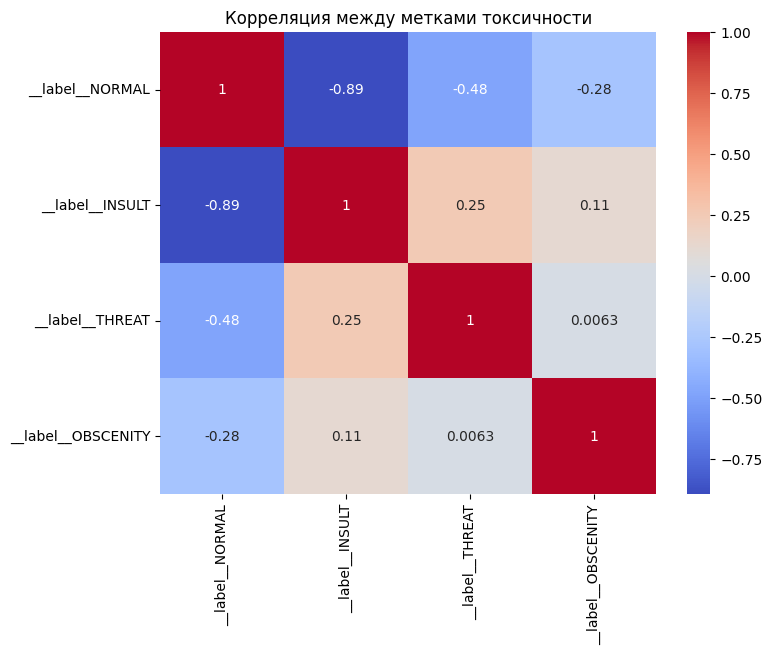

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[main_labels].corr(), annot=True, cmap='coolwarm')
plt.title('Корреляция между метками токсичности')
plt.show()

In [15]:
from sklearn.utils import resample

# 1. Загружаем и копируем DataFrame
df_balanced = df.copy()

# 2. Объединяем токсичные метки в одну категорию
toxic_labels = ['__label__INSULT', '__label__THREAT', '__label__OBSCENITY']

# Создаем новый бинарный признак TOXIC
df_balanced['TOXIC'] = df_balanced[toxic_labels].any(axis=1).astype(int)

# Теперь делим на две группы
normal_df = df_balanced[df_balanced['TOXIC'] == 0]
toxic_df = df_balanced[df_balanced['TOXIC'] == 1]

# 3. Балансировка: урезаем нормальные и/или увеличиваем токсичные
# а) Уменьшаем количество нормальных (например, до 60 000)
normal_sampled = normal_df.sample(n=60000, random_state=42)

# б) Увеличиваем токсичные до 60 000 путём сэмплирования с повторением
toxic_upsampled = resample(toxic_df,
                           replace=True,
                           n_samples=60000,
                           random_state=42)

# 4. Объединяем сбалансированные данные
df_final = pd.concat([normal_sampled, toxic_upsampled])

# 5. Перемешиваем
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

# 6. Проверим баланс
print(df_final['TOXIC'].value_counts())

TOXIC
1    60000
0    60000
Name: count, dtype: int64


обучение с использованием TF-IDF + Logistic Regression

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Выделяем признаки и целевую переменную
X = df_final['cleaned_text']
y = df_final['TOXIC']

# Разделим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Инициализация TF-IDF векторизатора
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

# Преобразование текста в векторы
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

обучение модели

In [18]:
from sklearn.linear_model import LogisticRegression

# Обучаем модель
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

оценка модели

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.88      0.94      0.91     12007
       TOXIC       0.94      0.87      0.90     11993

    accuracy                           0.91     24000
   macro avg       0.91      0.91      0.91     24000
weighted avg       0.91      0.91      0.91     24000



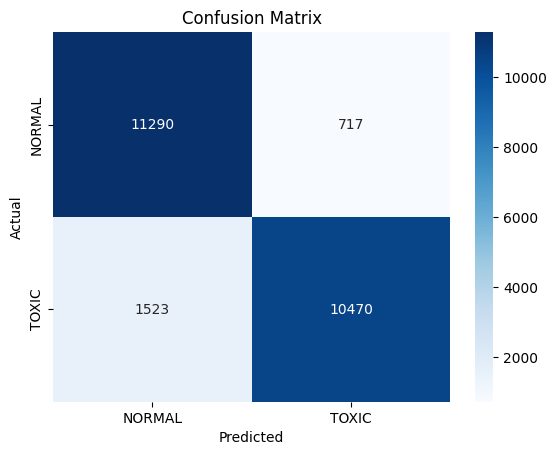

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

# Предсказание
y_pred = clf.predict(X_test_tfidf)

# Метрики качества
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "TOXIC"]))

# Матрица ошибок
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["NORMAL", "TOXIC"], yticklabels=["NORMAL", "TOXIC"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [22]:
def predict_toxicity(text):
    cleaned = clean_text(text)
    vectorized = vectorizer.transform([cleaned])
    prediction = clf.predict(vectorized)[0]
    probability = clf.predict_proba(vectorized)[0][1]
    return {
        'text': text,
        'cleaned': cleaned,
        'is_toxic': bool(prediction),
        'confidence': round(probability, 3)
    }

# Пример
example = predict_toxicity("ты тупая мразь")
example1 = predict_toxicity("какой прекрасный день!")

print(example, example1)

{'text': 'ты тупая мразь', 'cleaned': 'ты тупая мразь', 'is_toxic': True, 'confidence': np.float64(0.998)} {'text': 'какой прекрасный день!', 'cleaned': 'какой прекрасный день', 'is_toxic': False, 'confidence': np.float64(0.05)}


In [23]:
pip install fastapi uvicorn scikit-learn joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.7 MB/s eta 0:00:00


In [26]:
import joblib

joblib.dump(clf, 'toxic_classifier.joblib')
joblib.dump(vectorizer, 'vectorizer.joblib')

['vectorizer.joblib']